In [39]:
import os
import zipfile
import tensorflow as tf
import tensorflow_hub as hub

### Import Dataset

In [40]:
path = 'dataset'
isExist = os.path.exists(path)
if not isExist:
  os.makedirs(path)

In [41]:
# download zip file dataset, and put it in base dir.
zip_path = './dataset.zip'
zip_ref = zipfile.ZipFile(zip_path, 'r')
zip_ref.extractall(path='./dataset/')

zip_ref.close()

In [28]:
base_dir = 'dataset'

print("Contents of base directory:")
print(os.listdir(base_dir))

print("\nContents of train directory:")
print(os.listdir(f'{base_dir}/train'))

print("\nContents of train directory:")
print(os.listdir(f'{base_dir}/test'))

Contents of base directory:
['test', 'train']

Contents of train directory:
['caries', 'no-caries']

Contents of train directory:
['caries', 'no-caries']


In [30]:
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

train_caries_dir = os.path.join(train_dir, 'caries')
train_nocaries_dir = os.path.join(train_dir, 'no-caries')

test_caries_dir = os.path.join(test_dir, 'caries')
test_nocaries_dir = os.path.join(test_dir, 'no-caries')

In [35]:
train_caries_fnames = os.listdir( train_caries_dir )
train_nocaries_fnames = os.listdir( train_nocaries_dir )

In [31]:
print('total training caries images :', len(os.listdir(      train_caries_dir ) ))
print('total training no caries images :', len(os.listdir(      train_nocaries_dir ) ))

print('total test caries images :', len(os.listdir( test_caries_dir ) ))
print('total test no caries images :', len(os.listdir( test_nocaries_dir ) ))

total training caries images : 242
total training no caries images : 15
total test caries images : 28
total test no caries images : 4


In [33]:
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

nrows = 4
ncols = 4

pic_index = 0

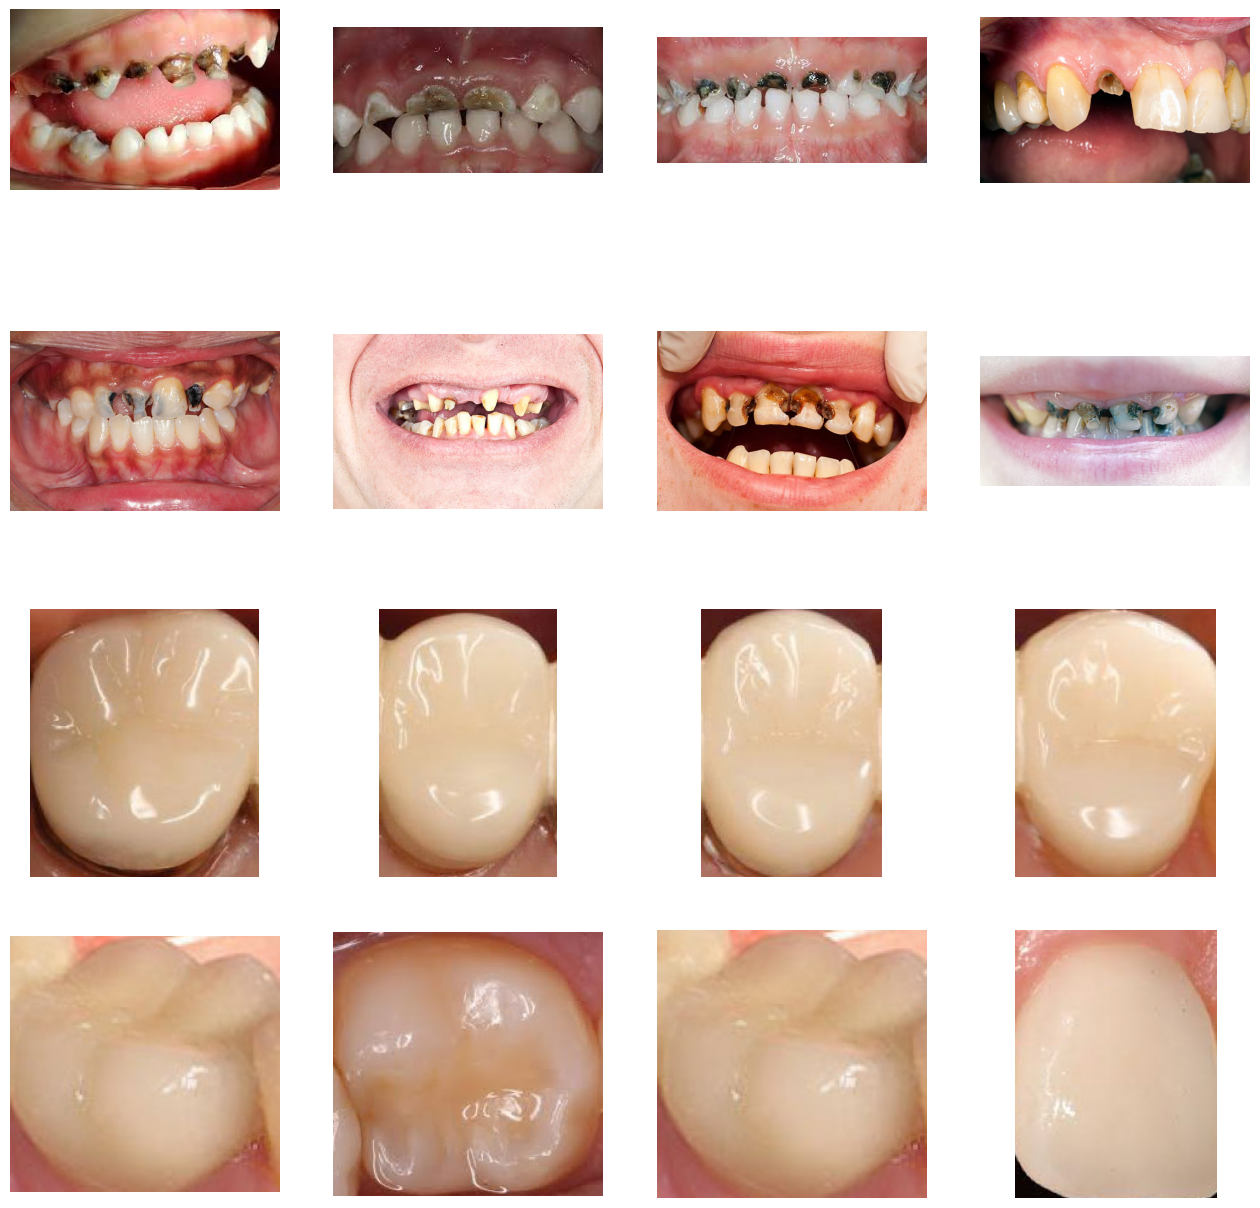

In [36]:
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index+=8

next_caries_pix = [os.path.join(train_caries_dir, fname) 
                for fname in train_caries_fnames[ pic_index-8:pic_index] 
               ]

next_nocaries_pix = [os.path.join(train_nocaries_dir, fname) 
                for fname in train_nocaries_fnames[ pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_caries_pix+next_nocaries_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

### Building Model using Transfer Learning

In [7]:
# transfer learning
model_selection = ("mobilenet_v2", 224, 1280) 
handle_base, pixels, FV_SIZE = model_selection
IMAGE_SIZE = (pixels, pixels)

MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/4".format(handle_base)
feature_extractor = hub.KerasLayer(MODULE_HANDLE, input_shape=IMAGE_SIZE + (3,))
feature_extractor.trainable = True

### Preprocessing Image using ImageDataGenerator